In [76]:
import numpy as np
from tifffile import imread
from os import listdir
from pymatreader import read_mat
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [94]:
tiffs = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/tiffs")
sound = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/sound_file_2022-07-12_16-39-18_cs_17_T5_s2")
stimHist = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/stimHistory_17t5.mat")
specs = Path("specs")

def sequence(start, end):
    res = []
    diff = 1
    x = start
    while x <= end:
        res.append(x)
        x += diff
    return res

class NeuralDataset(Dataset) :
#tiff_path is path to .tiff files containing widefield images
#spec_path is path to spectrograms
#timeStamps is .mat file that is stims x nReps, containing frame info
  def __init__(self, tiff_path, spec_path, timeStamps, transforms = None):
    self.path_to_tiff = tiff_path
    self.tiffs = listdir(tiff_path)
    self.specs = listdir(spec_path)
    self.timeStamps = read_mat(timeStamps)['stimHistory']
    self.transform = transforms
  
  def __len__(self):
    return len(self.specs)

  def __getitem__(self, idx):
    #load 30 image stack, tiffs in 9798 n stacks
    reps = []
    for i in range(2) :
        start = self.timeStamps[idx, i]

        #check that this is alright
        end = self.timeStamps[idx, i] + 29
        tempStart = start
        counterS = 0
        tempEnd = end
        counterE = 0
        #basically figures out what stack the start and end frames are in
        if start > 9797 or end > 9797 :
            while tempStart > 9797 :
                counterS += 1
                tempStart -= 9797
            while tempEnd > 9797 :
                counterE += 1
                tempEnd -= 9797

        #if start and end of sequence are in same stack
        if counterE == counterS :
            seq = sequence(tempStart, tempEnd)
            neurons = imread(Path(self.path_to_tiff, self.tiffs[counterS]), key = seq)
            neurons = ToTensor()(neurons.astype(float))
            neurons = neurons.movedim(1, 0)
            reps.append(neurons)
        #if they are in different stacks
        #to test
        else :
            seq = sequence(tempStart, 9798)
            neurons_stack1 = imread(self.tiffs[counterS], key = seq)
            seq = sequence(1, tempEnd)
            neurons_stack2 = imread(self.tiffs[counterE], key = seq)
            neurons = ToTensor()(neurons_stack1.astype(float) + neurons_stack2.astype(float))
            neurons = neurons.movedim(1, 0)
            reps.append(neurons)
        
    spec = torchvision.io.read_image("specs/" + self.specs[idx])
    neurons = torch.stack((reps[0], reps[1]), 0)
    return neurons, spec


dataset = NeuralDataset(tiffs, specs, stimHist)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

#for i, (neurons, specs) in enumerate(dataloader):
        #print("Excerpt", i, "from Valley of the Yucas by Rufus du Sol")
        #img = specs.detach()
        #img = F.to_pil_image(img)
        #plt.imshow(np.asarray(img))

In [92]:
neu, spec = dataset[0]

torch.Size([2, 30, 330, 330])


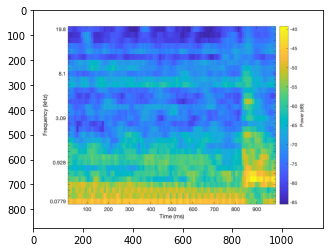

In [93]:
print(neu.shape)

img = spec.detach()
img = F.to_pil_image(img)
plt.imshow(np.asarray(img))

torch.Size([30, 330, 330])


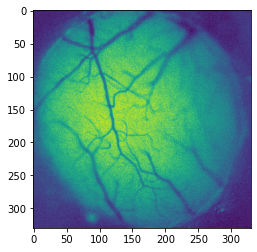

In [98]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

recording = neu[0]
print(recording.shape)

frames = [[ax.imshow(recording[i])] for i in range(30)]
ani = animation.ArtistAnimation(fig, frames)
ani